# Introduction

In this tutorial, we do sentiment analysis using the deep learning classifier from Keras. We use the airline sentiment data from earlier workshops. We introduce the use of Keras 

We'll do the following:
- Fit a deep learning model with Keras using dense feedforward network
- Identify and deal with overfitting
- Test the accuracy of a pretrained model

## Set-up of the project
We'll start by importing some packages. The Keras is a backend to the DL libraries - tensorflow, Theano or CNTK. Installation may be done using https://keras.io/#installation It recenty release the Keras 2.0, and we can use the latest version for this purpose.

In [1]:
# Basic packages
# use kernel hug
# conda install nb_conda --> to install kernel with tensorflow virtualenv
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
import keras
from keras import models
from keras import layers
from keras import regularizers
import tensorflow as tf
print (keras.__version__)

2.4.2


Using TensorFlow backend.


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

Then we set some parameters that will be used throughout the notebook. The batch size is the number of samples processed before the model is updated. The number of epochs is the number of complete passes (iteration) through the training dataset.

In [3]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary to create word vector
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

Reading in the data and doing some pre-processing. 

In [4]:
df = pd.read_csv('data/airline_sentiment.csv')#)
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
11736,@USAirways thanks. _Ù÷Õ,positive
13944,@AmericanAir Dallas/Fort Worth flight number 5320,neutral
14052,"@AmericanAir I need to get from Albuquerque, N...",neutral
2805,@united we can't all be american airlines I su...,negative
10872,@USAirways delayed I'm charlotte big surprise,negative


In [5]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isstyc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()

,text,airline_sentiment
11736,thanks. _Ù÷Õ,positive
13944,Dallas/Fort Worth flight number 5320,neutral
14052,"need get Albuquerque, NM, USA, Cebu, Philippi...",neutral
2805,can't american airlines suppose... http://t.c...,negative
10872,delayed I'm charlotte big surprise,negative


Segment the data into test and train data sets. 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13176
# Test data samples: 1464


In [9]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

In [10]:
print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 13176 documents
10000 words in dictionary
Top 5 most common words are: [('flight', 3532), ('not', 1424), ('no', 1356), ('get', 1208), ('t', 1104)]


In [11]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

" What  said." is converted into [174, 2, 161, 662, 194, 167, 33, 569, 2116, 1510, 613, 13, 459, 37, 652, 472, 118]


One hot encoding is very explained [in this link.](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f#targetText=One%20hot%20encoding%20is%20a,the%20entry%20in%20the%20dataset)
Essentially, it is a binary indicator of whether a feature (word etc) exists in the training documents or not. It is used in this instance as instead of showing the positional index of a particular word, it indicates 1/0 if the word is present in the document.
    

In [12]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

In [13]:
X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[174, 2, 161, 662, 194, 167, 33, 569, 2116, 1510, 613, 13, 459, 37, 652, 472, 118]" is converted into [0. 0. 1. ... 0. 0. 0.]
For this example we have 17.0 features with a value of 1.


In [14]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)
print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"neutral" is converted into 0
"0" is converted into [1. 0. 0.]


In [15]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1318, 10000)


### Set-up of Dense Feedforward Classifier
The model used is a sequential model with 2 intermediate hidden layers. In the input layer, there are 64 neurons (what is described as a perceptron). As there are 10000 words, total no of parameters in the first layer = 64*10000 + 64 (for constants) = 640064.

In the 2nd layer, this takes the output from the 1st layer (64 outputs from the 64 neurons) Total no of parameters = 64-64 + 64 = 4160.

There are 3 outputs (shape) from the last output layer which correspond to probabilities of the 3 classes - positive, negative and neutral. Total no of parameters = 64* 3 +3 = 195

The Dense FNN is the simplest model that should be understood first in DL.

In [16]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


Next, the model is compiled. The loss function is meant for categorical classifications. 
$-(y log(p) + (1-y) log(1-p))$ So suppose for a positive label, and the classifier classes the positive/ negative classes as (0.8,0.2), $p=0.8, y=1$ for the cross entropy calculated as $0.223$. If it classifies as 100% positive, the cross entropy is 0.

In [17]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history
base_history = deep_model(base_model)

Note the below, where with the no of epochs (iterations), the train loss decreases. However, the validation losses increases. This is a symptom of over-fitting. Too often, this occurs for deep learning. The same thing occurs for the accuracy, which increases for the training set but remain stagnant for the validation set.

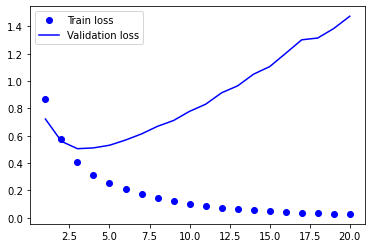

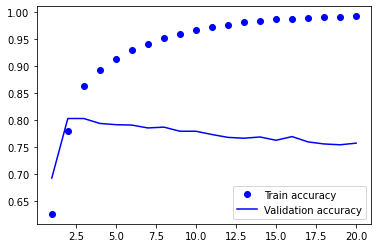

In [18]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()
    
eval_metric(base_history, 'loss')
eval_metric(base_history, 'accuracy')

In the next example, what we do is to remove one hidden layer and also decrease the no of neurons from 64 to 32. This will hopefully reduce over-fitting

In [19]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

reduced_history = deep_model(reduced_model)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


### Less over-fitting with reduced model
Indeed as we observe, the baseline model sees increasing losses while the reduced model (with fewer neurons and one hidden layer less) loss does not increase even with increasing epochs.

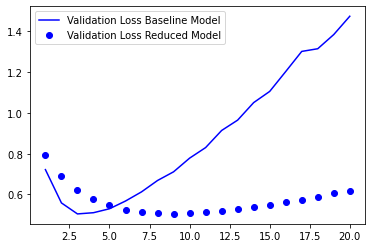

In [20]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'b', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'bo', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()
    
compare_loss_with_baseline(reduced_history, 'Reduced Model')

### Reduce over-fitting with regularizer

Another method to reduce over-fitting is adding a penalty through a regularizer, which relays the weights in each layer to the final loss function. Again as seen below, the regularised model sees a consistent loss relative to the baseline model.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


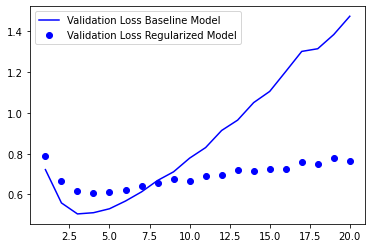

In [21]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()
    
reg_history = deep_model(reg_model)
compare_loss_with_baseline(reg_history, 'Regularized Model')

### Reducing over-fitting by dropping
A third way to reduce over-fitting is by randomly dropping data-sets for training. In this case, an additional hidden layer is used to drop some of the intermediate training data. As observed below, the validation losses remain consistent.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


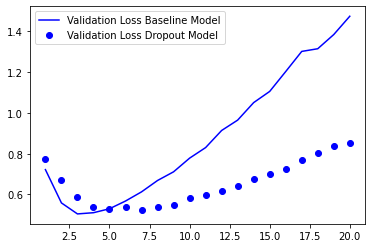

In [22]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

drop_history = deep_model(drop_model)

compare_loss_with_baseline(drop_history, 'Dropout Model')

### Testing model results
We use out models for in-sample testing of the data. In fact the 3 models (regularised, drop-out and reduced models) all work well in spite of controlling for over-fitting as seen by a higher accuracy.

In [23]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

46/46 [==============================] - 0s 3ms/step - loss: 1.1862 - accuracy: 0.7520
/n
Test accuracy of baseline model: 75.20%


In [24]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

46/46 [==============================] - 0s 2ms/step - loss: 0.7887 - accuracy: 0.7671
/n
Test accuracy of reduced model: 76.71%
46/46 [==============================] - 0s 2ms/step - loss: 0.7883 - accuracy: 0.7643
/n
Test accuracy of regularized model: 76.43%
46/46 [==============================] - 0s 2ms/step - loss: 0.9234 - accuracy: 0.7794
/n
Test accuracy of dropout model: 77.94%
